<a href="https://colab.research.google.com/github/nicolastibata/MINE_4210_ADL_202520/blob/main/labs/Laboratorio_6/MINE__4210_ADL_202520_L6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/nicolastibata/MINE_4210_ADL_202520/blob/main/docs/images/logo.png?raw=true)


# **Laboratorio 6: Despliegue de una red convolucional CNN**
**Tutor: Nicolás Tibatá**

## **Tabla de Contenido**

[Contexto y objetivos](#scrollTo=5KnQpgpopi8a)<br>
[1. Introducción de los datos](#scrollTo=VjA8zwzJvmeO)<br>
[2. Preparación y Modelamiento](#scrollTo=kG8XHROzvuEH)<br>
[3. Despliegue](#scrollTo=JTKc52_Wvs_N)<br>

## Contexto y objetivos

**Problema**
- En este caso exploraremos el dataset "Cat & Dog". Este dataset cuenta con 25000 imágenes. Las imágenes presentan diversas dimensiones, siendo 100x100 la más común. El objetivo es construir un clasificador a través del algoritmo de CNN que pueda distinguir entre cada uno de estos animales.

**Objetivos**
1. Construir un modelo CNN.
2. Desplegar el modelo en Streamlit.

**Datos**

Los datos los puedes consultar [aquí](https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification).

### **1. Introducción a los datos**

In [1]:
# Instalación e Importación de librerías
!pip install keras-tuner -q

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import image as mping
from skimage.io import imread
from skimage.transform import resize
from pathlib import Path
from PIL import Image as PImage
from PIL import ImageDraw
from IPython.display import display

from google.colab import files
from google.colab import userdata



from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


In [2]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification
!unzip "cat-dog-images-for-classification.zip"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: cat_dog/dog.5499.jpg    
  inflating: cat_dog/dog.55.jpg      
  inflating: cat_dog/dog.550.jpg     
  inflating: cat_dog/dog.5500.jpg    
  inflating: cat_dog/dog.5501.jpg    
  inflating: cat_dog/dog.5502.jpg    
  inflating: cat_dog/dog.5503.jpg    
  inflating: cat_dog/dog.5504.jpg    
  inflating: cat_dog/dog.5505.jpg    
  inflating: cat_dog/dog.5506.jpg    
  inflating: cat_dog/dog.5507.jpg    
  inflating: cat_dog/dog.5508.jpg    
  inflating: cat_dog/dog.5509.jpg    
  inflating: cat_dog/dog.551.jpg     
  inflating: cat_dog/dog.5510.jpg    
  inflating: cat_dog/dog.5511.jpg    
  inflating: cat_dog/dog.5512.jpg    
  inflating: cat_dog/dog.5513.jpg    
  inflating: cat_dog/dog.5514.jpg    
  inflating: cat_dog/dog.5515.jpg    
  inflating: cat_dog/dog.5516.jpg    
  inflating: cat_dog/dog.5517.jpg    
  inflating: cat_dog/dog.5518.jpg    
  inflating: cat_dog/dog.5519.jpg    
  inflating: cat_dog/dog.55

In [3]:
data = pd.read_csv('/content/cat_dog.csv')
data.head()
#dog = 1 & cat = 0

,image,labels
0,dog.11289.jpg,1
1,cat.10836.jpg,0
2,cat.7970.jpg,0
3,cat.2212.jpg,0
4,dog.2653.jpg,1


(352, 349, 3)


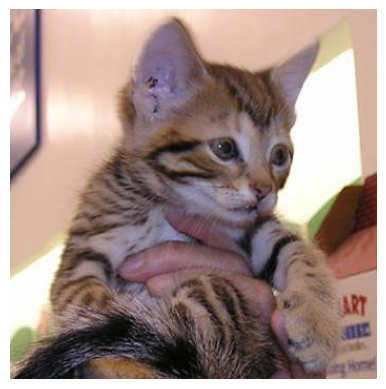

In [4]:
img = imread("/content/cat_dog/cat.12461.jpg")
plt.imshow(img)
print(img.shape)
plt.axis('off')
plt.show()

### **2. Preparación y Modelamiento**

#### **Preparación**

In [5]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [6]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.1)
callbacks = [earlystop, learning_rate_reduction]

In [7]:
data["labels"] = data["labels"].replace({1: "Dog", 0: "Cat"})
data.head()
# Se hace para el ImageDataGenerator

,image,labels
0,dog.11289.jpg,Dog
1,cat.10836.jpg,Cat
2,cat.7970.jpg,Cat
3,cat.2212.jpg,Cat
4,dog.2653.jpg,Dog


In [8]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=19)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=19)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [9]:
total_train = train_data.shape[0]
total_test = test_data.shape[0]
batch_size = 15

In [10]:
def create_augmented_datagen():
    return ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=[0.9, 1.1],
        fill_mode='nearest'
    )

def create_validation_datagen():
    return ImageDataGenerator(rescale=1./255)  # Solo normalización


train_datagen = create_augmented_datagen()    # CON augmentation
val_datagen = create_validation_datagen()     # SIN augmentation
test_datagen = create_validation_datagen()    # SIN augmentation

train_generator = train_datagen.flow_from_dataframe(
    train_data,  # Tu DataFrame de train
    "/content/cat_dog",
    x_col='image',
    y_col='labels',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True  # Shuffle para train
)

val_generator = val_datagen.flow_from_dataframe(
    val_data,    # Tu DataFrame de validation
    "/content/cat_dog",
    x_col='image',
    y_col='labels',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False  # No shuffle para validation
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,   # Tu DataFrame de test
    "/content/cat_dog",
    x_col='image',
    y_col='labels',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False  # No shuffle para test
)

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


**Veamos un ejemplo del data augmentation**

Found 1 validated image filenames belonging to 1 classes.


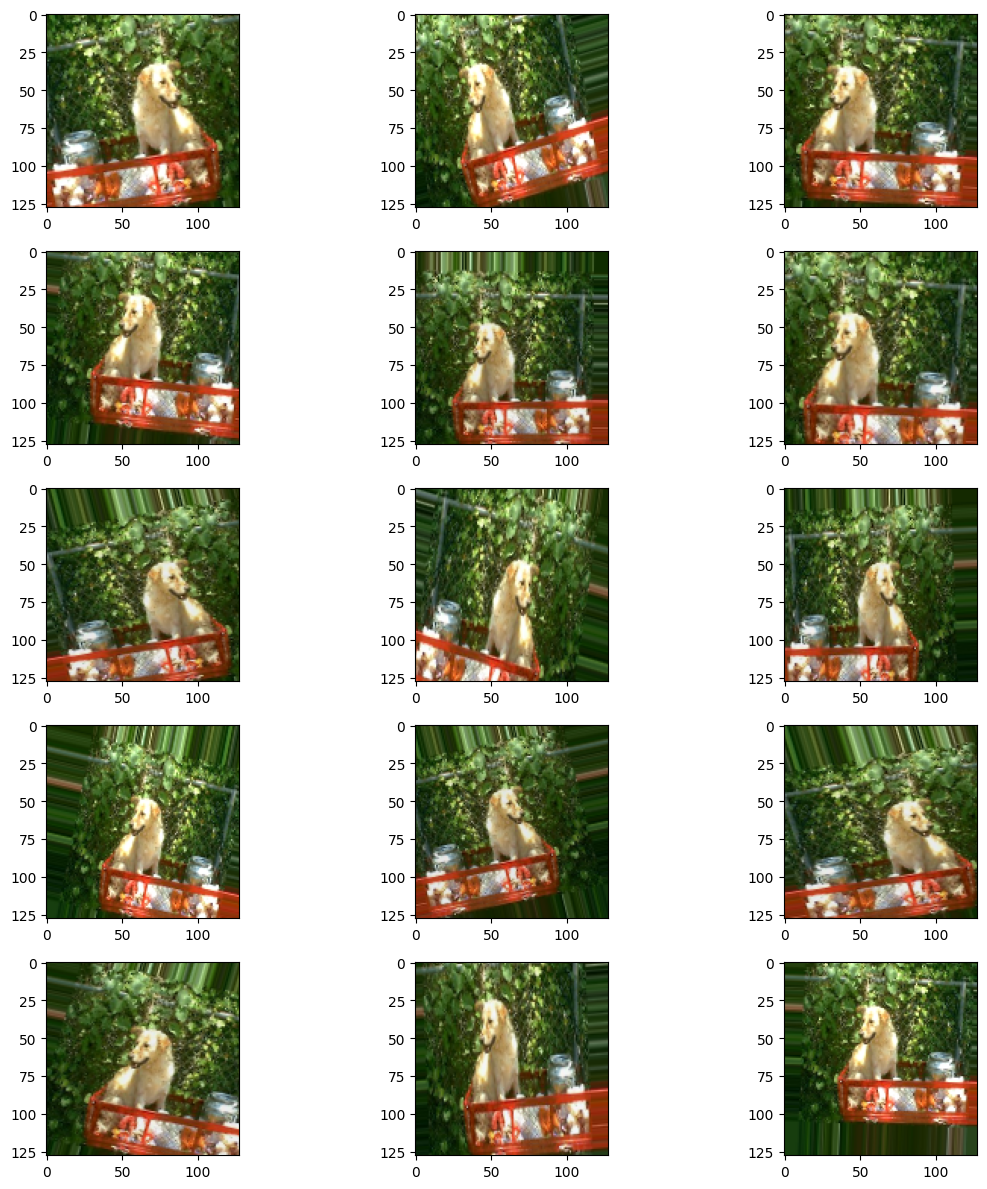

In [11]:
example_df = train_data.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/cat_dog", # Modify to your directory path
    x_col='image',
    y_col='labels',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#### **Modelamiento**

In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))) # Ajustar dimensiones en streamlit
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,942,786 (49.37 MB)

 Trainable params: 12,941,314 (49.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [13]:
epochs= 10 if FAST_RUN else 20
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=total_test//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 128s 111ms/step - accuracy: 0.5836 - loss: 1.0094 - val_accuracy: 0.6595 - val_loss: 0.7099 - learning_rate: 0.0010
Epoch 2/20
   1/1066 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.6667 - loss: 0.6539

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1066/1066 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6667 - loss: 0.6539 - val_accuracy: 0.6643 - val_loss: 0.6834 - learning_rate: 0.0010
Epoch 3/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 100s 93ms/step - accuracy: 0.6876 - loss: 0.6013 - val_accuracy: 0.6712 - val_loss: 0.7359 - learning_rate: 0.0010
Epoch 4/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6000 - loss: 0.8164 - val_accuracy: 0.6967 - val_loss: 0.6200 - learning_rate: 0.0010
Epoch 5/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 100s 94ms/step - accuracy: 0.7369 - loss: 0.5410 - val_accuracy: 0.7820 - val_loss: 0.5006 - learning_rate: 0.0010
Epoch 6/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8667 - loss: 0.6513 - val_accuracy: 0.7935 - val_loss: 0.4811 - learning_rate: 0.0010
Epoch 7/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 138s 95ms/step - accuracy: 0.7612 - loss: 0.5129 - val_accuracy: 0.7790 - val_loss: 0.4782 - learning_rate: 0.0010
Epoch 8/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9333 -

In [14]:
test_filenames = os.listdir("/content/cat_dog")
test_df = pd.DataFrame({
    'image': test_filenames
})
nb_samples = test_df.shape[0]

In [15]:
predict = model.predict(test_generator)

334/334 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step


In [16]:
label_encoder = LabelEncoder()
true_classes = label_encoder.fit_transform(test_data['labels'].values)

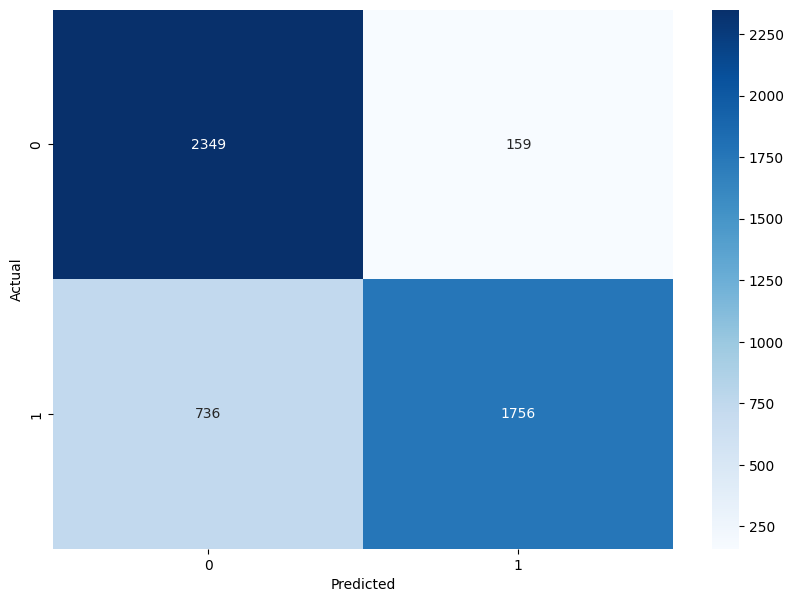

In [17]:
predicted_classes = np.argmax(predict, axis=1)
label_encoder = LabelEncoder()
true_classes = label_encoder.fit_transform(test_data['labels'].values)

cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

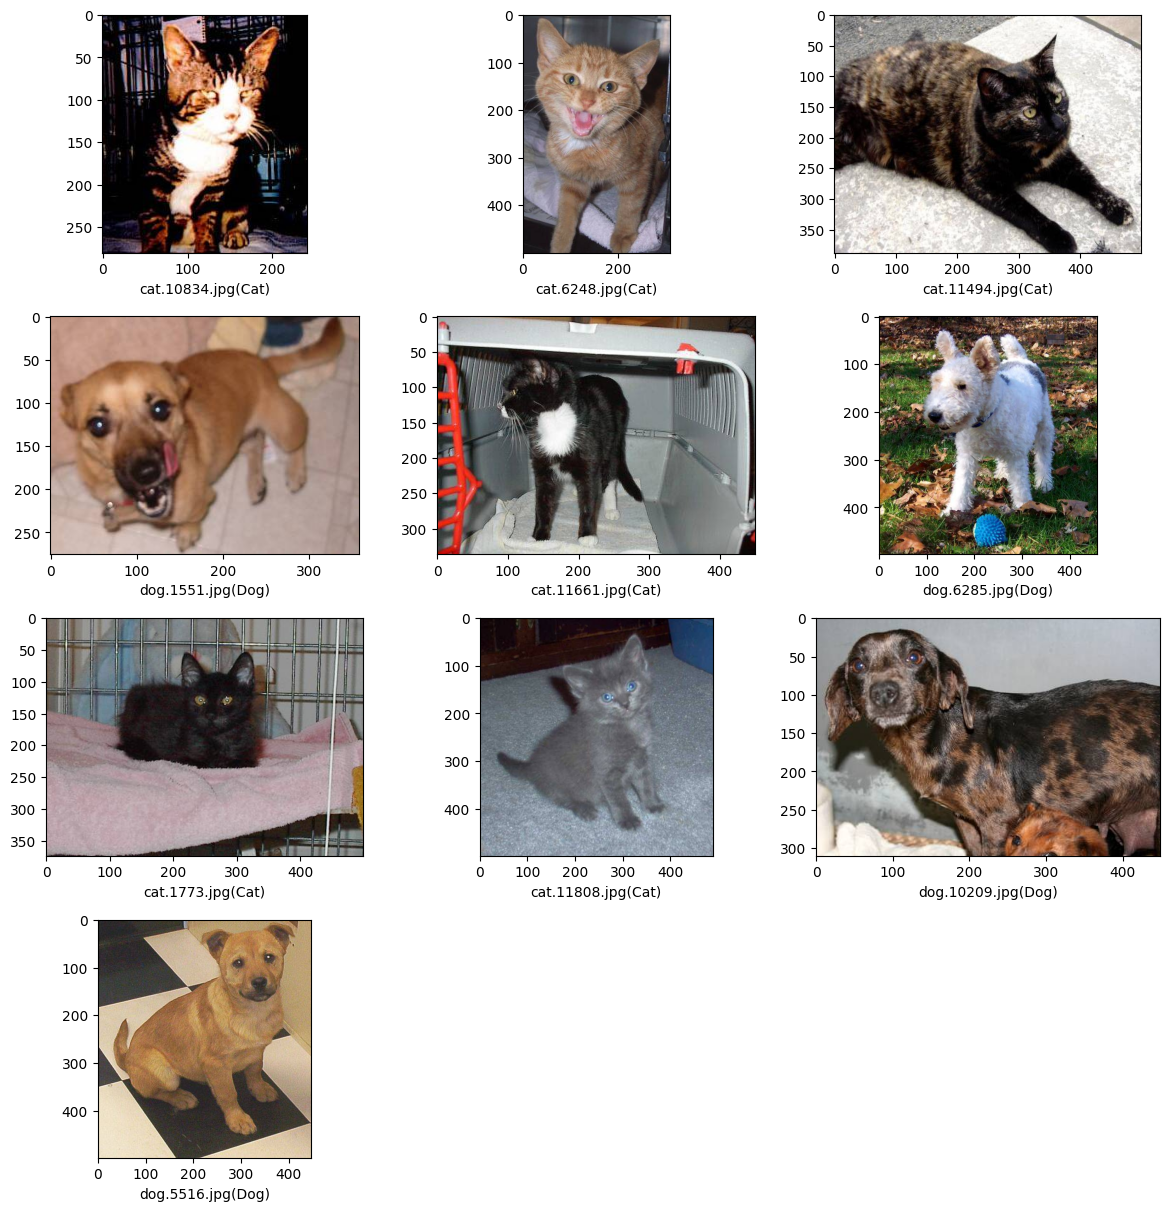

In [19]:
sample_test = test_data.head(10)
sample_test.head()
plt.figure(figsize=(12, 51))
for index, row in sample_test.iterrows():
    filename = row['image']
    category = row['labels']
    img = np.array(mping.imread("/content/cat_dog/" + filename))
    plt.subplot(17, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [20]:
# Guardar modelo completo en formato nativo de Keras
model.save('my_cat_dog_model.keras')  # Nuevo formato
model.save('my_cat_dog_model.h5')     # Formato clásico

In [21]:
# Lo descargamos en local
files.download("/content/my_cat_dog_model.keras")
files.download("/content/my_cat_dog_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **3. Despliegue**

Streamlit es un marco de desarrollo de código abierto en Python, se destaca por su capacidad para facilitar la creación de aplicaciones web interactivas y visualizaciones de datos de forma eficiente. Su singularidad radica en su enfoque hacia la simplicidad y facilidad de uso, permitiendo a los desarrolladores construir aplicaciones web con un mínimo de código.

Necesitamos 4 cosas fundamentales:
1. `app.py`
2. `requirements.txt`
3. `modelo_nn.keras`
4. Repo en github

Si queremos testear en local necesitamos un ambiente virtual (venv o conda) para el cual se tienen instaladas las librerias streamlit, tensorflow o las necesarias para el desarrollo.


Link streamlit: https://mine4210-lab6-170925.streamlit.app/
